## Data Exploration and Preprocessing


In [54]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
%matplotlib inline
import dateutil
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [55]:
# dataloading
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [56]:
# Portfolio data overview
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [57]:
portfolio_clean = portfolio.copy()

# All media types available in my dataset
media = ['web', 'email', 'mobile', 'social']

# Create columns for all media
for medium in media:
    portfolio_clean['ch_' + medium] = portfolio_clean['channels'].str.contains(medium, regex=False)

# Changing new column order for the dataset
new_col_order = [
    'id', 'offer_type', 'difficulty', 'duration', 'reward',
    'ch_web', 'ch_email', 'ch_mobile', 'ch_social'
]
portfolio_clean = portfolio_clean[new_col_order]

# Rename ids from the dataset
old_to_new_ids = {
    'ae264e3637204a6fb9bb56bc8210ddfd': 'bogo1',
    '4d5c57ea9a6940dd891ad53e9dbe8da0': 'bogo2',
    '3f207df678b143eea3cee63160fa8bed': 'info1',
    '9b98b8c7a33c4b65b9aebfe6a799e6d9': 'bogo3',
    '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'discount1',
    '2298d6c36e964ae4a3e7e9706d1fb8c2': 'discount2',
    'fafdcd668e3743c1bb461111dcafc2a4': 'discount3',
    '5a8bc65990b245e5a138643cd4eb9837': 'info2',
    'f19421c1d4aa40978ebb69ca19b0e20d': 'bogo4',
    '2906b810c7d4411798c6938adc9daaa5': 'discount4'
}
portfolio_clean['id'] = portfolio_clean['id'].map(old_to_new_ids) 

# cleaned data
portfolio_clean

,id,offer_type,difficulty,duration,reward,ch_web,ch_email,ch_mobile,ch_social
0,bogo1,bogo,10,7,10,False,True,True,True
1,bogo2,bogo,10,5,10,True,True,True,True
2,info1,informational,0,4,0,True,True,True,False
3,bogo3,bogo,5,7,5,True,True,True,False
4,discount1,discount,20,10,5,True,True,False,False
5,discount2,discount,7,7,3,True,True,True,True
6,discount3,discount,10,10,2,True,True,True,True
7,info2,informational,0,3,0,False,True,True,True
8,bogo4,bogo,5,5,5,True,True,True,True
9,discount4,discount,10,7,2,True,True,True,False


#### Statistics Part

In [58]:
portfolio_clean.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [59]:
portfolio_clean[['difficulty', 'duration', 'reward']].kurtosis()

difficulty    1.347032
duration     -0.584304
reward       -0.455486
dtype: float64

In [60]:
# Overview of profile data
print("Profile: {} records".format(profile.shape[0]))
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile.head()

Profile: 17000 records


,age,became_member_on,gender,id,income
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [61]:
# Data types overview of data
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null datetime64[ns]
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 664.1+ KB


In [62]:
# counting of Missing values
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [63]:
profile[profile['age']==118].sample(10)

,age,became_member_on,gender,id,income
13587,118,2017-06-18,None,69426d0b7c344fe68f6271ea3d06b804,NaN
9736,118,2017-12-09,None,f9007a7d6a2742908b93fe151311e205,NaN
9640,118,2017-08-16,None,7f4e982a72f14c619d2c4e29b1ec9806,NaN
5030,118,2017-05-21,None,62964b89979b4e91b8d33ff7d2cf4e86,NaN
3733,118,2016-09-13,None,2a2434a742fc40df952c536485bb205a,NaN
560,118,2016-06-05,None,2afcff4b5f4c42fc98b0280a0c8febc9,NaN
16285,118,2016-01-03,None,8b2aa1d1e2c8463c91d5d49b63f6821e,NaN
13423,118,2017-06-15,None,56204fd4a6a448a8b7f6696dade64912,NaN
57,118,2015-12-20,None,4be1127413db496d8103c783ae72058b,NaN
13456,118,2017-04-18,None,58d8b6173f00448892e69d63c0cc9670,NaN


In [64]:
profile_clean = profile.copy()

person_id_map = {}
count = 1
for id_ in profile_clean.id.unique():
    person_id_map[id_] = 'person' + str(count)
    count = count+1
# renameing
profile_clean['id'] = profile_clean['id'].map(person_id_map)

# Droping of the missing values
profile_clean = profile_clean.dropna()

# cleande dataframe dataframe
profile_clean.head()

,age,became_member_on,gender,id,income
1,55,2017-07-15,F,person2,112000.0
3,75,2017-05-09,F,person4,100000.0
5,68,2018-04-26,M,person6,70000.0
8,65,2018-02-09,M,person9,53000.0
12,58,2017-11-11,M,person13,51000.0


## Visualization

In [65]:
profile_clean.describe()

,age,income
count,14825.000000,14825.000000
mean,54.393524,65404.991568
std,17.383705,21598.299410
min,18.000000,30000.000000
25%,42.000000,49000.000000
50%,55.000000,64000.000000
75%,66.000000,80000.000000
max,101.000000,120000.000000


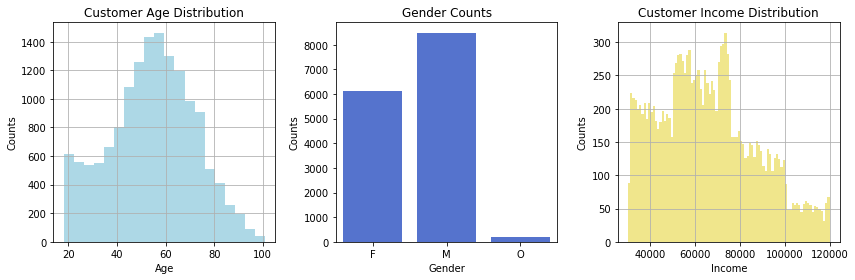

In [66]:
plt.figure(figsize=(12,4))

# plotting of age distribution of the data
plt.subplot(131)
profile_clean['age'].hist(bins=20, color='lightblue')
plt.title('Customer Age Distribution');
plt.ylabel('Counts');
plt.xlabel('Age');

# plotting of gender distribution of the data
plt.subplot(132)
sns.countplot(profile_clean['gender'].fillna('Unknown'), color='royalblue');
plt.ylabel('Counts');
plt.xlabel('Gender');
plt.title('Gender Counts')

# Age distribution
plt.subplot(133)
profile_clean['income'].hist(bins=90, color='khaki')
plt.title('Customer Income Distribution');
plt.ylabel('Counts');
plt.xlabel('Income');

plt.tight_layout()

In [67]:
# Skewness of the graph can be viewed through skew()
profile_clean.skew()

age      -0.080766
income    0.402005
dtype: float64

In [68]:
profile_clean.kurtosis()

age      -0.502684
income   -0.558372
dtype: float64

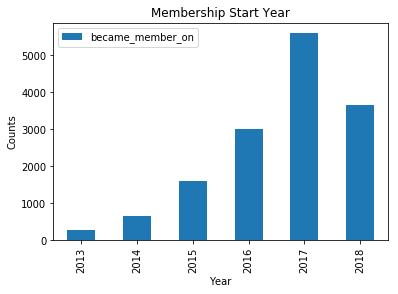

In [69]:
profile_clean[['became_member_on']].groupby([profile.became_member_on.dt.year]).count().plot.bar(width=0.5);
plt.title('Membership Start Year');
plt.ylabel('Counts');
plt.xlabel('Year');

In [70]:
# Overview of transcript data
print("Transcript: {} records".format(transcript.shape[0]))
transcript.head()

Transcript: 306534 records


,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [71]:
# Data types
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [72]:
# Statistics
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [73]:
# differnet event types
transcript.event.unique().tolist()

['offer received', 'offer viewed', 'transaction', 'offer completed']

In [74]:
print('unique customer: {}'.format(transcript.person.nunique()))
print('Average offers : {}'.format(np.round(transcript.shape[0]/transcript.person.nunique(),0)))

unique customer: 17000
Average offers : 18.0


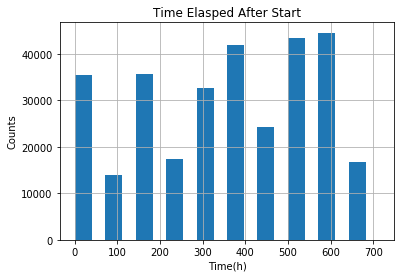

In [75]:
# Test time elapsed
transcript.time.hist(width=40);
plt.title('Time Elasped After Start');
plt.ylabel('Counts');
plt.xlabel('Time(h)');

In [76]:
# Event and actions
for event in transcript.event.unique().tolist():
    print('### {} ###'.format(event))
    print(transcript[transcript['event']==event][['event','value']].head(3))
    print()

### offer received ###
            event                                             value
0  offer received  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1  offer received  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2  offer received  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}

### offer viewed ###
              event                                             value
12650  offer viewed  {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
12651  offer viewed  {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
12652  offer viewed  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}

### transaction ###
             event                           value
12654  transaction  {'amount': 0.8300000000000001}
12657  transaction               {'amount': 34.56}
12659  transaction               {'amount': 13.23}

### offer completed ###
                 event                                              value
12658  offer completed  {'offer_id': '2906b810c7d4411798c6938adc9daaa5...
12672

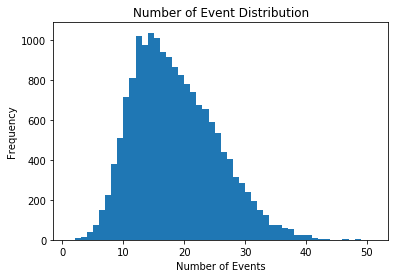

In [77]:
# Total event number for each person
transcript.groupby('person').size().plot.hist(bins=50)
plt.title('Number of Event Distribution');
plt.ylabel('Frequency');
plt.xlabel('Number of Events');

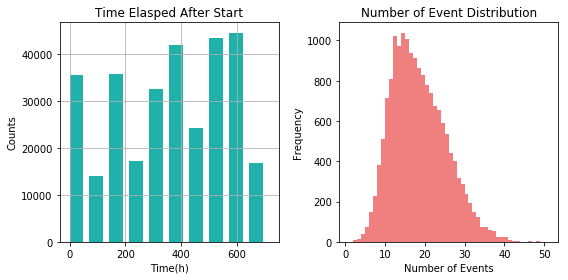

In [78]:
plt.figure(figsize=(8,4))

# Age distribution
plt.subplot(121)
transcript.time.hist(width=50, color='lightseagreen');
plt.title('Time Elasped After Start');
plt.ylabel('Counts');
plt.xlabel('Time(h)');

# Genders
plt.subplot(122)
transcript.groupby('person').size().plot.hist(bins=50, color='lightcoral')
plt.title('Number of Event Distribution');
plt.ylabel('Frequency');
plt.xlabel('Number of Events');

plt.tight_layout()

In [79]:
transcript[transcript['person'] == transcript.person.sample().values[0]]

,event,person,time,value
2885,offer received,f883a0574d944b0488bca8cc4b22a728,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
28241,offer viewed,f883a0574d944b0488bca8cc4b22a728,42,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
29873,transaction,f883a0574d944b0488bca8cc4b22a728,48,{'amount': 30.25}
29874,offer completed,f883a0574d944b0488bca8cc4b22a728,48,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...
42316,transaction,f883a0574d944b0488bca8cc4b22a728,102,{'amount': 23.93}
50643,transaction,f883a0574d944b0488bca8cc4b22a728,150,{'amount': 15.96}
56104,offer received,f883a0574d944b0488bca8cc4b22a728,168,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
90898,offer viewed,f883a0574d944b0488bca8cc4b22a728,234,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
113732,offer received,f883a0574d944b0488bca8cc4b22a728,336,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
124408,offer viewed,f883a0574d944b0488bca8cc4b22a728,336,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}


In [80]:
# how many uniques are
transcript['person'].nunique()

17000

In [81]:
transaction_clean = transcript[transcript['event'] == 'transaction'].copy()
transaction_clean['amount'] = transaction_clean['value'].apply(lambda x: x['amount'])
transaction_clean = transaction_clean.drop(['event', 'value'], axis=1)

# Rename person
transaction_clean['person'] = transaction_clean['person'].map(person_id_map)

# Resulting dataframe
transaction_clean.head()

,person,time,amount
12654,person42,0,0.83
12657,person56,0,34.56
12659,person64,0,13.23
12670,person135,0,19.51
12671,person152,0,18.97


In [82]:
# Extract offer related data
offer_reaction_clean = transcript[transcript['event'] != 'transaction'].copy()
offer_reaction_clean['offer_id'] = offer_reaction_clean['value'].apply(lambda x: x['offer_id'] if 'offer_id' in x else x['offer id'])
offer_reaction_clean = offer_reaction_clean.drop(['value'], axis=1)

# Rename offer ids
offer_reaction_clean['offer_id'] = offer_reaction_clean['offer_id'].map(old_to_new_ids)

# Rename person
offer_reaction_clean['person'] = offer_reaction_clean['person'].map(person_id_map)

# Resulting dataframe
offer_reaction_clean.head()

,event,person,time,offer_id
0,offer received,person4,0,bogo3
1,offer received,person5,0,discount1
2,offer received,person6,0,discount4
3,offer received,person7,0,discount3
4,offer received,person8,0,bogo2


In [83]:
portfolio_clean.head(3)

,id,offer_type,difficulty,duration,reward,ch_web,ch_email,ch_mobile,ch_social
0,bogo1,bogo,10,7,10,False,True,True,True
1,bogo2,bogo,10,5,10,True,True,True,True
2,info1,informational,0,4,0,True,True,True,False


In [84]:
profile_clean.head(3)

,age,became_member_on,gender,id,income
1,55,2017-07-15,F,person2,112000.0
3,75,2017-05-09,F,person4,100000.0
5,68,2018-04-26,M,person6,70000.0


In [85]:
transaction_clean.head(3)

,person,time,amount
12654,person42,0,0.83
12657,person56,0,34.56
12659,person64,0,13.23


In [86]:
offer_reaction_clean.head(3)

,event,person,time,offer_id
0,offer received,person4,0,bogo3
1,offer received,person5,0,discount1
2,offer received,person6,0,discount4


## 2. Data Understaning

In [87]:
portfolio_clean

,id,offer_type,difficulty,duration,reward,ch_web,ch_email,ch_mobile,ch_social
0,bogo1,bogo,10,7,10,False,True,True,True
1,bogo2,bogo,10,5,10,True,True,True,True
2,info1,informational,0,4,0,True,True,True,False
3,bogo3,bogo,5,7,5,True,True,True,False
4,discount1,discount,20,10,5,True,True,False,False
5,discount2,discount,7,7,3,True,True,True,True
6,discount3,discount,10,10,2,True,True,True,True
7,info2,informational,0,3,0,False,True,True,True
8,bogo4,bogo,5,5,5,True,True,True,True
9,discount4,discount,10,7,2,True,True,True,False


In [88]:
# Offer Reaction for customers
print("Offer Reaction: {} records".format(offer_reaction_clean.shape[0]))
offer_reaction_clean[['event', 'offer_id']].sample(5)

Offer Reaction: 167581 records


,event,offer_id
120048,offer received,bogo1
117125,offer received,info1
211286,offer received,bogo1
151275,offer received,discount3
67957,offer viewed,discount4


#### 3. Data Preparation


In [89]:
# Make a copy
df_Q1 = portfolio_clean.copy()

# Features to used in this section
df_Q1[['id', 'offer_type', 'difficulty', 'reward']]

,id,offer_type,difficulty,reward
0,bogo1,bogo,10,10
1,bogo2,bogo,10,10
2,info1,informational,0,0
3,bogo3,bogo,5,5
4,discount1,discount,20,5
5,discount2,discount,7,3
6,discount3,discount,10,2
7,info2,informational,0,0
8,bogo4,bogo,5,5
9,discount4,discount,10,2


In [90]:
# Compute statistics
offer_statistics = []
for offer_id in offer_reaction_clean['offer_id'].unique():
    offer_stat = offer_reaction_clean[offer_reaction_clean['offer_id'] == offer_id].groupby('event').size().to_dict()
    offer_stat['id'] = offer_id
    offer_statistics.append(offer_stat)

df_offer_stat = pd.DataFrame(offer_statistics)[['id', 'offer received', 'offer viewed', 'offer completed']]

df_offer_stat['offer_complete_rate'] = df_offer_stat['offer completed'] / df_offer_stat['offer received']
df_offer_stat['offer_view_rate'] = df_offer_stat['offer viewed'] / df_offer_stat['offer received']

df_offer_stat

,id,offer received,offer viewed,offer completed,offer_complete_rate,offer_view_rate
0,bogo3,7677,4171,4354.0,0.567149,0.543311
1,discount1,7668,2663,3420.0,0.446009,0.347287
2,discount4,7632,4118,4017.0,0.526336,0.539570
3,discount3,7597,7327,5317.0,0.699882,0.964460
4,bogo2,7593,7298,3331.0,0.438694,0.961148
5,bogo4,7571,7264,4296.0,0.567428,0.959451
6,discount2,7646,7337,5156.0,0.674340,0.959587
7,info1,7617,4144,NaN,NaN,0.544046
8,bogo1,7658,6716,3688.0,0.481588,0.876991
9,info2,7618,6687,NaN,NaN,0.877789


In [91]:
# Joinning of the dataset
df_Q1 = df_Q1.join(df_offer_stat.set_index('id'), on='id').drop(['offer received', 'offer viewed', 'offer completed'], axis=1)
df_Q1 = df_Q1[['id', 'offer_type', 'difficulty', 'duration', 'reward', 'offer_complete_rate', 'offer_view_rate']]

In [92]:
df_Q1

,id,offer_type,difficulty,duration,reward,offer_complete_rate,offer_view_rate
0,bogo1,bogo,10,7,10,0.481588,0.876991
1,bogo2,bogo,10,5,10,0.438694,0.961148
2,info1,informational,0,4,0,NaN,0.544046
3,bogo3,bogo,5,7,5,0.567149,0.543311
4,discount1,discount,20,10,5,0.446009,0.347287
5,discount2,discount,7,7,3,0.674340,0.959587
6,discount3,discount,10,10,2,0.699882,0.964460
7,info2,informational,0,3,0,NaN,0.877789
8,bogo4,bogo,5,5,5,0.567428,0.959451
9,discount4,discount,10,7,2,0.526336,0.539570


## Results evaluation

In [93]:
# dropping
df_Q1_comp = df_Q1[['id', 'offer_type', 'offer_complete_rate']].sort_values(by='offer_complete_rate', ascending=False).dropna()
df_Q1_comp

,id,offer_type,offer_complete_rate
6,discount3,discount,0.699882
5,discount2,discount,0.674340
8,bogo4,bogo,0.567428
3,bogo3,bogo,0.567149
9,discount4,discount,0.526336
0,bogo1,bogo,0.481588
4,discount1,discount,0.446009
1,bogo2,bogo,0.438694


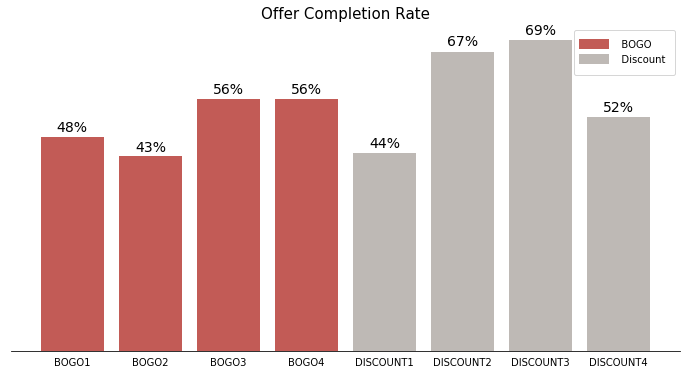

In [94]:
cate_colors = df_Q1_comp.offer_type.map({'bogo': '#c25b56', 'discount': '#beb9b5'})

df_Q1_comp['offer_complete_rate_per'] = df_Q1_comp['offer_complete_rate'].apply(lambda x: np.round(x*100, 2))

# Plottling
fig, ax = plt.subplots(figsize=(12,6))
bar_rect = ax.bar(x=df_Q1_comp['id'].str.upper(), height=df_Q1_comp['offer_complete_rate_per'], color=cate_colors)
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

custom_lines = [Line2D([0], [0], color='#c25b56', lw=10),
                Line2D([0], [0], color='#beb9b5', lw=10)]
ax.legend(custom_lines, ['   BOGO', '   Discount'], borderpad=1);

plt.tick_params(axis='x', which='both', bottom=False)

def autolabel(rects, unit=''):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        if height == 0: continue
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                '%d' % int(height) + unit,
                ha='center', va='bottom', fontsize=14)

# Label the percentage on top of bars
autolabel(bar_rect, '%')
plt.title('Offer Completion Rate', size=15);

In [95]:
# Avergage completion rate by type
df_Q1_comp.groupby(['offer_type']).mean()[['offer_complete_rate']]

,offer_complete_rate
offer_type,
bogo,0.513715
discount,0.586642


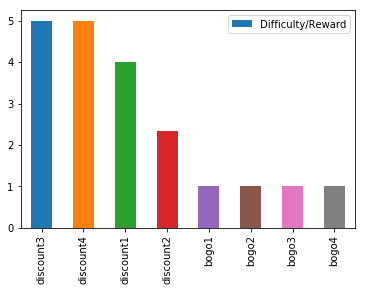

In [96]:
df_Q1['Difficulty/Reward'] = df_Q1['difficulty'] / df_Q1['reward']
df_Q1.sort_values(by='Difficulty/Reward', ascending=False).dropna().plot.bar(x='id', y='Difficulty/Reward');
plt.xlabel('');

In [97]:
# Data for view rate
df_Q1_view= df_Q1[['id', 'offer_type', 'offer_view_rate']].sort_values(by='offer_view_rate', ascending=False)
df_Q1_view

,id,offer_type,offer_view_rate
6,discount3,discount,0.964460
1,bogo2,bogo,0.961148
5,discount2,discount,0.959587
8,bogo4,bogo,0.959451
7,info2,informational,0.877789
0,bogo1,bogo,0.876991
2,info1,informational,0.544046
3,bogo3,bogo,0.543311
9,discount4,discount,0.539570
4,discount1,discount,0.347287


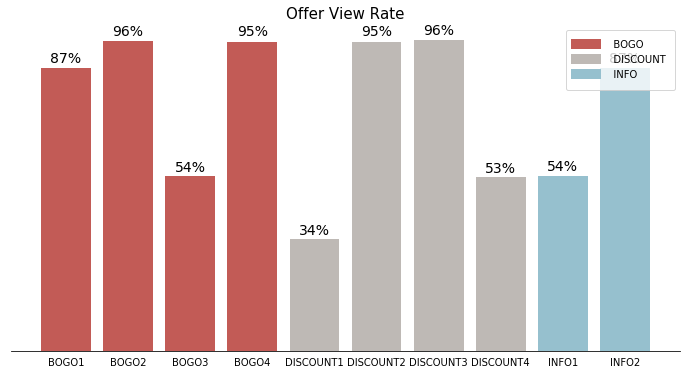

In [98]:
cate_colors = df_Q1_view.offer_type.map({'bogo': '#c25b56', 'discount': '#beb9b5', 'informational': '#96c0ce'})

# Percentage
df_Q1_view['offer_view_rate_per'] = df_Q1_view['offer_view_rate'].apply(lambda x: np.round(x*100, 2))

# Plottling
fig, ax = plt.subplots(figsize=(12,6))
bar_rect = ax.bar(x=df_Q1_view['id'].str.upper(), height=df_Q1_view['offer_view_rate_per'], color=cate_colors)
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

custom_lines = [Line2D([0], [0], color='#c25b56', lw=10),
                Line2D([0], [0], color='#beb9b5', lw=10),
                Line2D([0], [0], color='#96c0ce', lw=10)]
ax.legend(custom_lines, ['   BOGO', '   DISCOUNT', '   INFO'], borderpad=1);

plt.tick_params(axis='x', which='both', bottom=False)

def autolabel(rects, unit=''):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        if height == 0: continue
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                '%d' % int(height) + unit,
                ha='center', va='bottom', fontsize=14)

# Label the percentage on top of bars
autolabel(bar_rect, '%')
plt.title('Offer View Rate', size=15);

In [99]:
# Avergage view rate by type
df_Q1_view.groupby(['offer_type']).mean()[['offer_view_rate']]

,offer_view_rate
offer_type,
bogo,0.835225
discount,0.702726
informational,0.710918


##### (3) Offer Complete Rate correlation with other numerical parameters

In [100]:
# Correlation
q1_corr = df_Q1[['difficulty', 'duration', 'reward', 'offer_view_rate', 'offer_complete_rate']].corr()
q1_corr

,difficulty,duration,reward,offer_view_rate,offer_complete_rate
difficulty,1.000000,0.808414,0.465686,-0.300024,-0.487553
duration,0.808414,1.000000,0.160262,-0.255880,0.248762
reward,0.465686,0.160262,1.000000,0.224391,-0.697518
offer_view_rate,-0.300024,-0.255880,0.224391,1.000000,0.424601
offer_complete_rate,-0.487553,0.248762,-0.697518,0.424601,1.000000


In [101]:
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

q1_corr.style.background_gradient(cmap, axis=1).set_properties(**{'max-width': '80px', 'font-size': '10pt'}).set_precision(2)

,difficulty,duration,reward,offer_view_rate,offer_complete_rate
difficulty,1,0.81,0.47,-0.3,-0.49
duration,0.81,1,0.16,-0.26,0.25
reward,0.47,0.16,1,0.22,-0.7
offer_view_rate,-0.3,-0.26,0.22,1,0.42
offer_complete_rate,-0.49,0.25,-0.7,0.42,1


## 2. Data Understaning

In [102]:
profile_clean.head(3)

,age,became_member_on,gender,id,income
1,55,2017-07-15,F,person2,112000.0
3,75,2017-05-09,F,person4,100000.0
5,68,2018-04-26,M,person6,70000.0


In [103]:
transaction_clean.head(3)

,person,time,amount
12654,person42,0,0.83
12657,person56,0,34.56
12659,person64,0,13.23


In [104]:
# Offer reaction of customers
offer_reaction_clean.head(3)

,event,person,time,offer_id
0,offer received,person4,0,bogo3
1,offer received,person5,0,discount1
2,offer received,person6,0,discount4


## 3. Data Preparation

In [105]:
def printDictUpToNPairs(d, n):
    """ Print key-value pairs of given dictionary up to nth pair
    Args:
        d: Dictionray to be print
        n: Upper limit of the number of key-values printed
    Returns:
        None
    
    """
    if type(d) != dict:
        print('Argument d is not a dictionary')
        return
    
    for i, key in enumerate(d):
        if i >= n:
            break
        else:
            print('{} : {}'.format(key, d[key]))

In [108]:
spending_dict = transaction_clean.groupby(['person'])['amount'].sum().to_dict()
printDictUpToNPairs(spending_dict, 5)   

person1 : 20.4
person10 : 15.620000000000001
person100 : 34.04
person1000 : 19.78
person10000 : 7.279999999999999


In [109]:
# BOGO and DISCOUNT ids
bogo_ids = portfolio_clean[portfolio_clean.id.str.contains('bogo')].id.values
discount_ids = portfolio_clean[portfolio_clean.id.str.contains('discount')].id.values

# Compute person statistics
person_statistics = []
for person in offer_reaction_clean['person'].unique():
    # BOGO
    offer_bogo = offer_reaction_clean[offer_reaction_clean.offer_id.isin(bogo_ids)]
    offer_bogo = offer_bogo[offer_bogo['person'] == person].groupby('event').size()
    offer_bogo = offer_bogo.rename({'offer received': 'bogo offer received', 'offer viewed': 'bogo offer viewed', 'offer completed': 'bogo offer completed'})
    # DISCOUNT
    offer_discount = offer_reaction_clean[offer_reaction_clean.offer_id.isin(discount_ids)]
    offer_discount = offer_discount[offer_discount['person'] == person].groupby('event').size()
    offer_discount = offer_discount.rename({'offer received': 'discount offer received', 'offer viewed': 'discount offer viewed', 'offer completed': 'discount offer completed'})
    # Combine
    person_stat = offer_bogo.to_dict()
    person_stat.update(offer_discount.to_dict())
    person_stat['person'] = person
    person_statistics.append(person_stat)

# Dataframe, to pickle
fina_cols = ['person', 'bogo offer received', 'bogo offer viewed', 'bogo offer completed', 'discount offer received', 'discount offer viewed', 'discount offer completed']
df_person_stat = pd.DataFrame(person_statistics)[fina_cols].fillna(0)
df_person_stat.to_pickle("./person_statistics.pkl")

In [110]:
# Unpickle the dataframe
unpickled_df_person_stat = pd.read_pickle("./person_statistics.pkl")
unpickled_df_person_stat.head()

,person,bogo offer received,bogo offer viewed,bogo offer completed,discount offer received,discount offer viewed,discount offer completed
0,person4,3.0,3.0,3.0,0.0,0.0,0.0
1,person5,0.0,0.0,0.0,3.0,2.0,0.0
2,person6,1.0,1.0,1.0,2.0,2.0,1.0
3,person7,1.0,1.0,0.0,3.0,3.0,0.0
4,person8,3.0,2.0,0.0,2.0,2.0,0.0


In [111]:
unpickled_df_person_stat['bogo_offer_view_rate'] = unpickled_df_person_stat['bogo offer viewed'] / unpickled_df_person_stat['bogo offer received']
unpickled_df_person_stat['bogo_offer_complete_rate'] = unpickled_df_person_stat['bogo offer completed'] / unpickled_df_person_stat['bogo offer received']
unpickled_df_person_stat['discount_offer_view_rate'] = unpickled_df_person_stat['discount offer viewed'] / unpickled_df_person_stat['discount offer received']
unpickled_df_person_stat['discount_offer_complete_rate'] = unpickled_df_person_stat['discount offer completed'] / unpickled_df_person_stat['discount offer received']
unpickled_df_person_stat = unpickled_df_person_stat[['person', 'bogo_offer_view_rate', 'bogo_offer_complete_rate', 'discount_offer_view_rate', 'discount_offer_complete_rate']]
unpickled_df_person_stat.head(3)

,person,bogo_offer_view_rate,bogo_offer_complete_rate,discount_offer_view_rate,discount_offer_complete_rate
0,person4,1.0,1.0,NaN,NaN
1,person5,NaN,NaN,0.666667,0.0
2,person6,1.0,1.0,1.000000,0.5


In [112]:
# Create dataframe for later clustering task
df_Q2 = profile_clean.join(unpickled_df_person_stat.set_index('person'), on='id') # Append view/complete rate
df_Q2['spending'] = df_Q2['id'].map(spending_dict).fillna(0) # Add spending
#df_Q2['became_member_on'] = df_Q2['became_member_on'].dt.strftime('%Y') # Extract only year
df_Q2 = df_Q2.drop(['id'], axis=1)

# Take a look
df_Q2.head(3)

,age,became_member_on,gender,income,bogo_offer_view_rate,bogo_offer_complete_rate,discount_offer_view_rate,discount_offer_complete_rate,spending
1,55,2017-07-15,F,112000.0,0.0,1.0,NaN,NaN,77.01
3,75,2017-05-09,F,100000.0,1.0,1.0,NaN,NaN,159.27
5,68,2018-04-26,M,70000.0,1.0,1.0,1.0,0.5,57.73


In [113]:
df_Q2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 9 columns):
age                             14825 non-null int64
became_member_on                14825 non-null datetime64[ns]
gender                          14825 non-null object
income                          14825 non-null float64
bogo_offer_view_rate            13082 non-null float64
bogo_offer_complete_rate        13082 non-null float64
discount_offer_view_rate        13042 non-null float64
discount_offer_complete_rate    13042 non-null float64
spending                        14825 non-null float64
dtypes: datetime64[ns](1), float64(6), int64(1), object(1)
memory usage: 1.8+ MB


### Membership Duration

In [114]:
# latest membership date
print(df_Q2.became_member_on.max())

2018-07-26 00:00:00


In [115]:
# newest member list
newest_members = profile_clean[profile_clean.became_member_on == profile_clean.became_member_on.max()].id
# Hours after last membership date
hours_aft = transaction_clean[transaction_clean.person.isin(newest_members)].time.max()
# last transaction time: days after 2018-7-26
last_trans_time = df_Q2.became_member_on.max() + dateutil.relativedelta.relativedelta(hours=float(hours_aft))
print(last_trans_time)

2018-08-24 12:00:00


In [116]:
df_Q2['membership_duration'] = df_Q2['became_member_on'].apply(lambda x: (last_trans_time - x).days)
df_Q2 = df_Q2.drop(['became_member_on'], axis=1)
df_Q2[['age', 'gender', 'income', 'membership_duration', 'spending', 'bogo_offer_view_rate', 'bogo_offer_complete_rate', 'discount_offer_view_rate', 'discount_offer_complete_rate']].head(3)

,age,gender,income,membership_duration,spending,bogo_offer_view_rate,bogo_offer_complete_rate,discount_offer_view_rate,discount_offer_complete_rate
1,55,F,112000.0,405,77.01,0.0,1.0,NaN,NaN
3,75,F,100000.0,472,159.27,1.0,1.0,NaN,NaN
5,68,M,70000.0,120,57.73,1.0,1.0,1.0,0.5


In [117]:
df_Q2_cluster = df_Q2.drop(['bogo_offer_view_rate', 'bogo_offer_complete_rate', 'discount_offer_view_rate', 'discount_offer_complete_rate', 'spending'], axis=1).copy()

### One-hot Encoding through get_dummies() function

In [118]:
def one_hot(df, cols):
    """ One-hot encoding function
    Args:
        df: DataFrame
        cols: a list of columns to encode 
    Returns:
        a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop([each], axis=1)
    return df

In [119]:
# One-hot encode two categorical columns
df_Q2_cluster = one_hot(df_Q2_cluster, ['gender'])
df_Q2_cluster.head(3)

,age,income,membership_duration,gender_F,gender_M,gender_O
1,55,112000.0,405,1,0,0
3,75,100000.0,472,1,0,0
5,68,70000.0,120,0,1,0


### Standard Scaling

In [120]:
# data types
df_Q2_cluster.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 6 columns):
age                    14825 non-null int64
income                 14825 non-null float64
membership_duration    14825 non-null int64
gender_F               14825 non-null uint8
gender_M               14825 non-null uint8
gender_O               14825 non-null uint8
dtypes: float64(1), int64(2), uint8(3)
memory usage: 506.7 KB


In [121]:
columnsToEncode = list(df_Q2_cluster.select_dtypes(include=['int64','uint8']))
for col in columnsToEncode:
    df_Q2_cluster[col] = df_Q2_cluster[col].astype(np.float64)

In [122]:
# Apply feature scaling
scaler = StandardScaler()
for col in df_Q2_cluster.columns:
    df_Q2_cluster[col] = scaler.fit_transform(df_Q2_cluster[col].values.reshape(-1, 1))

# The resulting data set
df_Q2_cluster.head(3)

,age,income,membership_duration,gender_F,gender_M,gender_O
1,0.034889,2.157419,-0.349433,1.191146,-1.156702,-0.120448
3,1.185430,1.601801,-0.189601,1.191146,-1.156702,-0.120448
5,0.782741,0.212756,-1.029314,-0.839528,0.864527,-0.120448


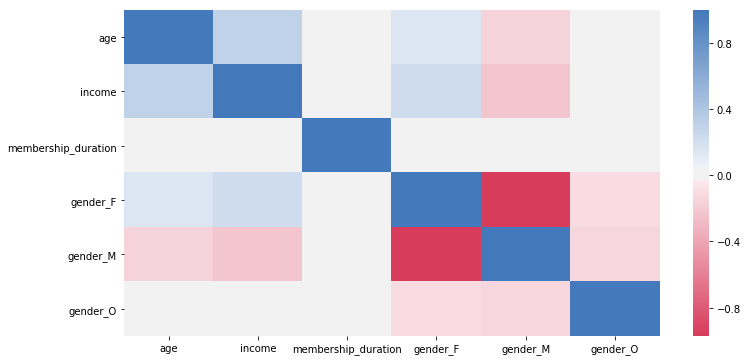

In [123]:
# Correlation Heatmap
plt.subplots(figsize=(12,6))
sns.heatmap(df_Q2_cluster.corr(), cmap=cmap)

### PCA

In [124]:
# All components
pca = PCA()
df_Q2_pca = pca.fit(df_Q2_cluster)

# Feature conversion matrix
dimensions = ['Dimension {}'.format(i) for i in range(1, len(pca.components_)+1)]
components = pd.DataFrame(np.round(pca.components_, 4), columns = df_Q2_cluster.keys())
components.index = dimensions

ratios = df_Q2_pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
variance_ratios.index = dimensions

# PCA result:
pca_result = pd.concat([variance_ratios, components], axis=1)
pca_result.head()

,Explained Variance,age,income,membership_duration,gender_F,gender_M,gender_O
Dimension 1,0.3578,0.2569,0.3235,-0.0124,0.6430,-0.6445,0.0184
Dimension 2,0.1915,-0.6578,-0.5789,-0.2386,0.2532,-0.2910,0.1624
Dimension 3,0.1711,0.1560,0.0853,-0.1205,-0.1829,-0.0479,0.9582
Dimension 4,0.1651,-0.1681,-0.0980,0.9627,0.0458,-0.0844,0.1617
Dimension 5,0.1145,0.6699,-0.7371,0.0400,0.0562,-0.0487,-0.0301


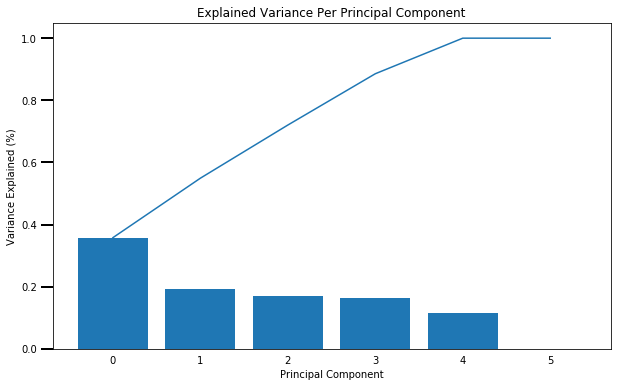

In [125]:
# Scree plot
num_components = len(df_Q2_pca.explained_variance_ratio_)
ind = np.arange(num_components)
vals = df_Q2_pca.explained_variance_ratio_

plt.figure(figsize=(10, 6))
ax = plt.subplot(111)
cumvals = np.cumsum(vals)
ax.bar(ind, vals)
ax.plot(ind, cumvals)
for i in range(num_components):
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title("Explained Variance Per Principal Component")

In [126]:
# Number of component to keep
n_keep = np.argwhere(cumvals>0.95)[0][0] + 1
print('Retained 95% variance by keeping more than {} components'.format(n_keep))

Retained 95% variance if keeping more than 5 components


In [128]:
# n_keep components
pca = PCA(n_components=n_keep, random_state=10)
df_Q2_pca = pca.fit_transform(df_Q2_cluster)

## Kmeans Clustering

In [129]:
def kmean_distance(data, n_centers):
    # Fit the data
    kmeans = KMeans(n_clusters=n_centers, random_state=10).fit(data)
    # Return sume of distances (negative score)
    return kmeans.inertia_

In [130]:
# Over a number of different cluster counts...
centers = [2, 5, 8, 11, 14, 17, 20]
sses = []
#sih_scores= []
for n in centers:
    # run k-means clustering on the data
    # compute the average within-cluster distances.
    sses.append(kmean_distance(df_Q2_pca, n))
    #sih_scores.append(kmean_silhouette_score(df_Q2_pca, n))

## Elbow method for the best number of clusters 

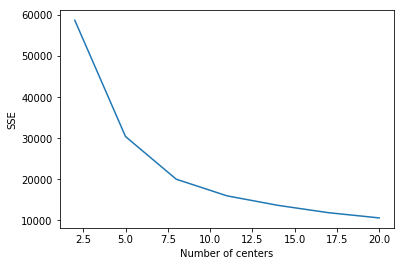

In [131]:
plt.plot(centers, sses)
plt.xlabel('Number of centers')
plt.ylabel('SSE')
plt.show()

In [132]:
# Segrementation
n_clusters = 8
model = KMeans(n_clusters=n_clusters, random_state=10).fit(df_Q2_pca)
cluster_pred = model.predict(df_Q2_pca)

## 5. Results evaluation

In [133]:
df_Q2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 9 columns):
age                             14825 non-null int64
gender                          14825 non-null object
income                          14825 non-null float64
bogo_offer_view_rate            13082 non-null float64
bogo_offer_complete_rate        13082 non-null float64
discount_offer_view_rate        13042 non-null float64
discount_offer_complete_rate    13042 non-null float64
spending                        14825 non-null float64
membership_duration             14825 non-null int64
dtypes: float64(6), int64(2), object(1)
memory usage: 1.8+ MB


In [134]:
# Divide the dataset according the clustering results
clusters = []
for i in range(n_clusters):
    clusters.append(df_Q2[cluster_pred==i])

In [135]:
df_Q2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 9 columns):
age                             14825 non-null int64
gender                          14825 non-null object
income                          14825 non-null float64
bogo_offer_view_rate            13082 non-null float64
bogo_offer_complete_rate        13082 non-null float64
discount_offer_view_rate        13042 non-null float64
discount_offer_complete_rate    13042 non-null float64
spending                        14825 non-null float64
membership_duration             14825 non-null int64
dtypes: float64(6), int64(2), object(1)
memory usage: 1.8+ MB


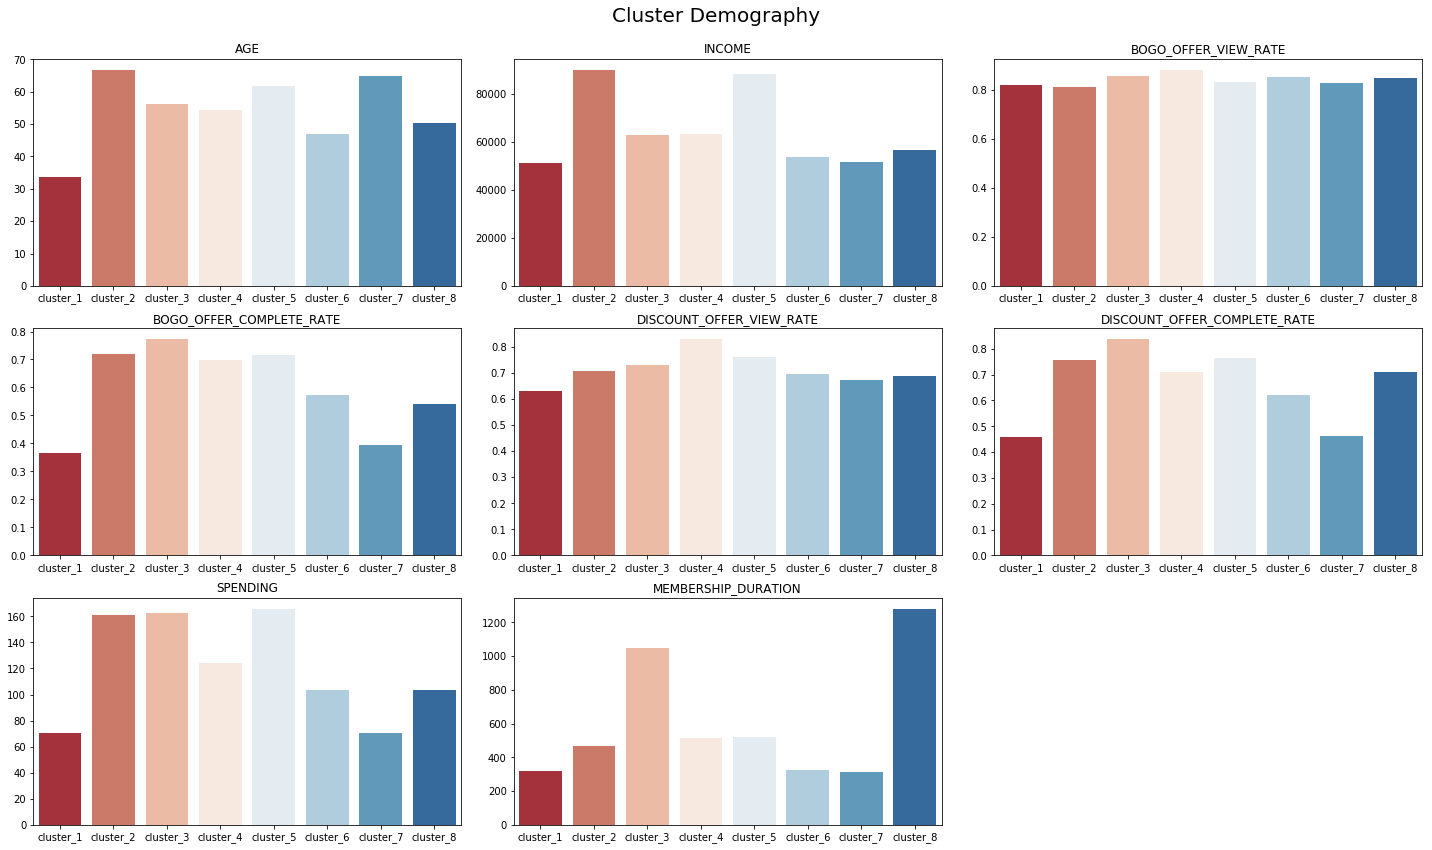

In [136]:
# Visualize various metrics among clusters
x_labels = ['cluster_{}'.format(n+1) for n in range(n_clusters)]
numerical_col_to_plot = [col for col in df_Q2.columns if df_Q2[col].dtype in [np.float64, np.int64]]
categorical_col_to_plot = [col for col in df_Q2.columns if df_Q2[col].dtype == object]

# Plot numerical features
fig = plt.figure(figsize=(20, 12))
fig.suptitle('Cluster Demography', fontsize=20)

n_fig_col = 3
n_fig_row = len(numerical_col_to_plot) // n_fig_col + 1
for n, col in enumerate(numerical_col_to_plot) :
    ax = fig.add_subplot(n_fig_row,n_fig_col, n+1)
    #plt.subplots(figsize=(10, 6))
    vals = []
    for i in range(n_clusters):
        vals.append(clusters[i][col].mean())
    sns.barplot(x_labels,vals, palette="RdBu", ax=ax)
    ax.set_title(col.upper())

plt.tight_layout()
fig.subplots_adjust(top=0.92)

In [137]:
# Check for gender split
for i, cluster in enumerate(clusters):
    print('clstr: ', i+1)
    print(cluster.gender.value_counts())

clstr:  1
M    2482
Name: gender, dtype: int64
clstr:  2
F    2618
Name: gender, dtype: int64
clstr:  3
F    1348
Name: gender, dtype: int64
clstr:  4
O    212
Name: gender, dtype: int64
clstr:  5
M    1993
Name: gender, dtype: int64
clstr:  6
F    2163
Name: gender, dtype: int64
clstr:  7
M    2296
Name: gender, dtype: int64
clstr:  8
M    1713
Name: gender, dtype: int64


It seems that K-Mean splits each cluster with a specific gender.

In [138]:
# Easy to read format
for i, cluster in enumerate(clusters):
    print('cluster {}: {}'.format(i+1, clusters[i].gender.mode().values[0]))

cluster 1: M
cluster 2: F
cluster 3: F
cluster 4: O
cluster 5: M
cluster 6: F
cluster 7: M
cluster 8: M


## Cluster Composition


In [139]:
def getRepresentativeMetrics(cluster_df):
    """Get Representative Metrics for cluster
    Args:
        cluster_df: cluster dataframe
    Returns:
        avg_age: average age
        avg_income: average income
        avg_member_duration: average membership duration in years
        gender: gender of the cluster
    """
    avg_age = np.round(cluster_df.age.mean(), 1)
    avg_income = np.round(cluster_df.income.mean(), 2)
    avg_member_duration = np.round(cluster_df.membership_duration.mean() / 365, 1)
    gender =  cluster_df.gender.mode().values[0]
    
    return avg_age, avg_income, avg_member_duration, gender

for ith_cluster in [2,3,5,1,7]:
    cluster_df = clusters[ith_cluster-1]
    avg_age, avg_income, avg_member_duration, gender = getRepresentativeMetrics(cluster_df)
    print('#### Cluster{} ####'.format(ith_cluster))
    print('Average age: ', avg_age, 'years old')
    print('Average income: ', avg_income, 'dollars')
    print('Average membership Duration: ', avg_member_duration, 'years')
    print('Gender: ', gender)
    print()

#### Cluster2 ####
Average age:  66.9 years old
Average income:  90258.59 dollars
Average membership Duration:  1.3 years
Gender:  F

#### Cluster3 ####
Average age:  56.2 years old
Average income:  62880.56 dollars
Average membership Duration:  2.9 years
Gender:  F

#### Cluster5 ####
Average age:  61.7 years old
Average income:  88345.21 dollars
Average membership Duration:  1.4 years
Gender:  M

#### Cluster1 ####
Average age:  33.8 years old
Average income:  51300.16 dollars
Average membership Duration:  0.9 years
Gender:  M

#### Cluster7 ####
Average age:  65.0 years old
Average income:  51686.41 dollars
Average membership Duration:  0.9 years
Gender:  M



## Conclusion
If the simulated app data is somewhat reflect the real behaviors of Starbucks customers, the following observations may be useful when choosing target customers to perform promotion.
* Women are more likely to respond to promotion(both BOGO and discount offers). 
* People with higher income are also more engaged in promotional offers.